BirdCLEF+ 2025 Sample Submission
This is a quick run through the submission process. Test data is hidden, so we can't access it before submission. In order to make a valid submission, here's what we'll do:

Make sure we predict for all 206 classes in the train data
Load a list of test soundscapes
Process each soundscape
load audio
split into 5-second chunks
run model inference for each chunk
save predictions
Make submission csv file
Submit
Ok, so here we go



In [2]:
# !pip install webrtcvad

https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

Testing CNN
https://ieeexplore.ieee.org/document/8741557


An Ensemble of Convolutional Neural Networks for Audio Classification
https://www.mdpi.com/2076-3417/11/13/5796


In [3]:
# First, let's import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import kagglehub
import soundfile as sf
import noisereduce as nr
from pydub import AudioSegment
import io
import wave
import struct
import soundfile as sf
import scipy.signal as signal
from scipy.io import wavfile
import webrtcvad
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

ROOT_DIR = os.getcwd()

/home/mcavoyst/miniconda3/envs/bird_env_11/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
2025-04-12 17:44:07.399877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744494247.487290  738997 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744494247.512625  738997 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744494247.694509  738997 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target 

In [4]:
# Class labels from train audio
class_labels = sorted(os.listdir(f'{ROOT_DIR}/kaggle/input/birdclef-2025/train_audio/'))

# List of test soundscapes (only visible during submission)
test_soundscape_path = f'{ROOT_DIR}/kaggle/input/birdclef-2025/test_soundscapes/'
test_soundscapes = [os.path.join(test_soundscape_path, afile) for afile in sorted(os.listdir(test_soundscape_path)) if afile.endswith('.ogg')]       

# List of train audio files
train_audio_path = f'{ROOT_DIR}/kaggle/input/birdclef-2025/train_audio/'


taxonomy = pd.read_csv(f'{ROOT_DIR}/kaggle/input/birdclef-2025/taxonomy.csv')
taxonomy.head(9)

primary_label  inat_taxon_id               scientific_name  \
0       1139490        1139490          Ragoniella pulchella   
1       1192948        1192948         Oxyprora surinamensis   
2       1194042        1194042           Copiphora colombiae   
3        126247         126247       Leptodactylus insularum   
4       1346504        1346504  Neoconocephalus brachypterus   
5        134933         134933        Espadarana prosoblepon   
6        135045         135045      Andinobates opisthomelas   
7       1462711        1462711         Cocconotus aratifrons   
8       1462737        1462737        Docidocercus fasciatus   

                    common_name class_name  
0          Ragoniella pulchella    Insecta  
1         Oxyprora surinamensis    Insecta  
2           Copiphora colombiae    Insecta  
3        Spotted Foam-nest Frog   Amphibia  
4  Neoconocephalus brachypterus    Insecta  
5            Emerald Glass Frog   Amphibia  
6            Andean Poison Frog   Amphibia  
7         Cocconotus aratifrons    Insecta  
8        Docidocercus fasciatus    Insecta

In [5]:
test_birds = taxonomy.query('common_name == ["Striped Cuckoo","Great Kiskadee", "White-tipped Dove"] ')['primary_label'].values
# kiskadee = taxonomy.query('common_name == "Great Kiskadee"')['primary_label'].values[0]

# cuckoo_dir = os.path.join(train_audio_path, cuckoo)
# cuckoo_files = [os.path.join(cuckoo_dir, afile) for afile in sorted(os.listdir(cuckoo_dir)) if afile.endswith('.ogg')]

test_birds


array(['grekis', 'strcuc1', 'whtdov'], dtype=object)

In [6]:
def play_ogg(file_path):
    """
    Play an .ogg file in a Jupyter notebook
    
    Parameters:
    file_path (str): Path to the .ogg file
    """
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return
    
    try:
        # Try loading with librosa first
        audio, sample_rate = librosa.load(file_path, sr=None)
    except:
        try:
            # If librosa fails, try with soundfile
            audio, sample_rate = sf.read(file_path)
        except Exception as e:
            print(f"Error loading audio file: {e}")
            return
    
    print(f"Playing: {os.path.basename(file_path)}")
    print(f"Duration: {len(audio) / sample_rate:.2f} seconds")
    print(f"Sample rate: {sample_rate} Hz")
    
    # Display audio player
    return ipd.Audio(audio, rate=sample_rate)



In [7]:
# First, let's import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Loading and Exploration

# Define directories
BIRD_CALL_DIR = os.path.join(ROOT_DIR, 'kaggle/input/birdclef-2025/train_audio')  # Update with your directories
BACKGROUND_NOISE_DIR = os.path.join(ROOT_DIR, 'kaggle/input/birdclef-2025/train_soundscapes')
# TEST_DATA_DIR = 'path/to/test_data/'

In [8]:
# Function to list all .ogg files in a directory
def list_ogg_files(directory):
    ogg_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.ogg'):
                ogg_files.append(os.path.join(root, file))
    return ogg_files

# Get file lists
# bird_call_files = list_ogg_files(BIRD_CALL_DIR) 

bird_call_files = [list_ogg_files(os.path.join(BIRD_CALL_DIR, bird)) for bird in test_birds]
bird_call_files = [item for sublist in bird_call_files for item in sublist]  # Flatten the list

#to numpy arry from list
print(f"Number of bird call files: {len(bird_call_files)}")
# bird_call_files = random.sample(bird_call_files, 300) #randomly select 10 files
bird_call_files, bird_test_files = train_test_split(bird_call_files, test_size=0.3, random_state=42)

print(f"Number of training files: {len(bird_call_files)}")
print(f"Number of testing files: {len(bird_test_files)}")


background_noise_files = list_ogg_files(BACKGROUND_NOISE_DIR)
background_noise_files, background_test_files = train_test_split(background_noise_files, test_size=0.3, random_state=42)

# background_noise_files = random.sample(background_noise_files, 100) #randomly select 10 files
# test_files = list_ogg_files(TEST_DATA_DIR)

print(f"Number of background noise files: {len(background_noise_files)}")
print(f"Number of testing background noise files: {len(background_test_files)}")
# print(f"Number of test files: {len(test_files)}")

play_ogg(bird_call_files[42])

Number of bird call files: 1993
Number of training files: 1395
Number of testing files: 598
Number of background noise files: 6808
Number of testing background noise files: 2918
Playing: XC129296.ogg
Duration: 35.06 seconds
Sample rate: 32000 Hz


In [9]:
play_ogg(background_noise_files[42])

Playing: H89_20230427_141500.ogg
Duration: 60.00 seconds
Sample rate: 32000 Hz


In [10]:
from tqdm import tqdm

Checking durations for 1395 audio files...


1395it [00:43, 31.77it/s]



Duration Summary Statistics:
Total files: 1395
Mean duration: 35.74 seconds
Min duration: 1.33 seconds
Max duration: 946.13 seconds


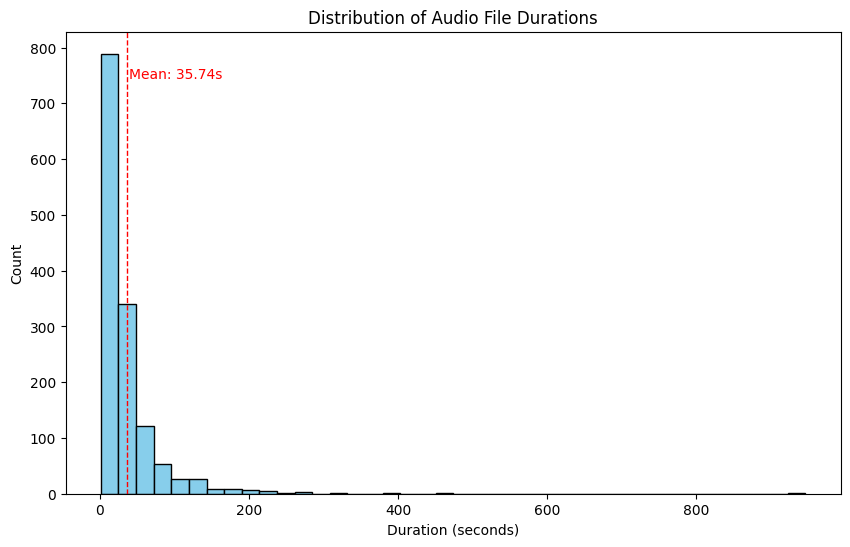

In [11]:
def check_audio_durations(file_list):
    """
    Check the duration of all audio files in a list
    
    Parameters:
    file_list (list): List of audio file paths
    
    Returns:
    pd.DataFrame: DataFrame with file names and durations
    """
    durations = []
    filenames = []
    sample_rates = []
    
    print(f"Checking durations for {len(file_list)} audio files...")
    
    for i, file_path in tqdm(enumerate(file_list)):
        try:
                
            # Load the audio file with librosa
            y, sr = librosa.load(file_path, sr=None)
            
            # Calculate duration in seconds
            duration = librosa.get_duration(y=y, sr=sr)
            
            durations.append(duration)
            filenames.append(os.path.basename(file_path))
            sample_rates.append(sr)
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            durations.append(None)
            filenames.append(os.path.basename(file_path))
            sample_rates.append(None)
    
    # Create a DataFrame
    duration_df = pd.DataFrame({
        'filename': filenames,
        'duration_seconds': durations,
        'sample_rate': sample_rates
    })
    
    # Print summary statistics
    print("\nDuration Summary Statistics:")
    print(f"Total files: {len(duration_df)}")
    print(f"Mean duration: {duration_df['duration_seconds'].mean():.2f} seconds")
    print(f"Min duration: {duration_df['duration_seconds'].min():.2f} seconds")
    print(f"Max duration: {duration_df['duration_seconds'].max():.2f} seconds")
    
    # Create a histogram of durations
    plt.figure(figsize=(10, 6))
    plt.hist(duration_df['duration_seconds'], bins=40, color='skyblue', edgecolor='black')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.title('Distribution of Audio File Durations')
    plt.axvline(duration_df['duration_seconds'].mean(), color='r', linestyle='dashed', linewidth=1)
    plt.text(duration_df['duration_seconds'].mean()*1.1, plt.ylim()[1]*0.9, 
             f'Mean: {duration_df["duration_seconds"].mean():.2f}s', color='r')
    plt.show()
    
    return duration_df

# Usage:
duration_df = check_audio_durations(bird_call_files)
# 
# Too short or too long files:
# short_files = duration_df[duration_df['duration_seconds'] < 1.0]
# long_files = duration_df[duration_df['duration_seconds'] > 60.0]

In [12]:
duration_df.describe()

duration_seconds  sample_rate
count       1395.000000       1395.0
mean          35.740956      32000.0
std           54.225562          0.0
min            1.332250      32000.0
25%           12.048000      32000.0
50%           21.524906      32000.0
75%           39.562016      32000.0
max          946.128000      32000.0

In [13]:
# 2. Audio Processing

# Function to extract bird species from filename (assuming filename format: 'species_id.ogg')
def extract_species(file_path):
    """
    Extract species name from the folder containing the file
    
    Parameters:
    file_path (str): Full path to the audio file
    
    Returns:
    species (str): Name of the species based on folder name
    """
    # Get the directory containing the file
    directory = os.path.dirname(file_path)
    
    # Extract the last folder name in the path
    species = os.path.basename(directory)
    
    return species

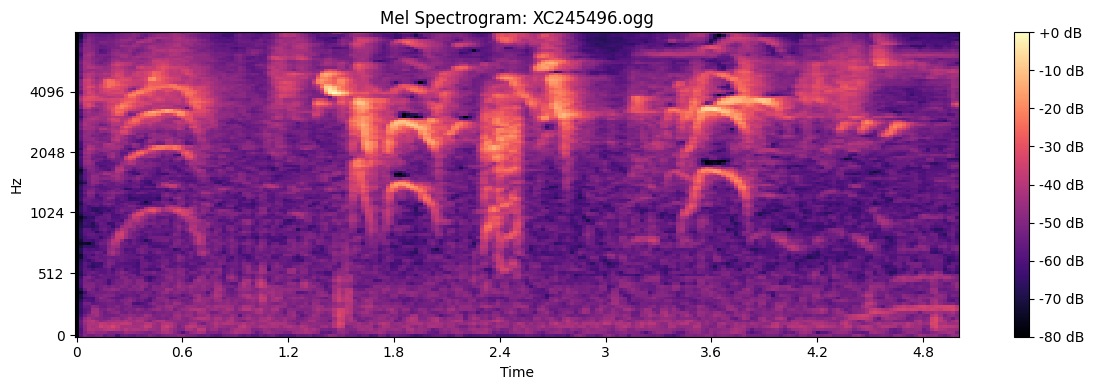

In [14]:
# Function to load and preprocess audio file
def preprocess_audio(file_path, sr=22050, duration=22):
    """
    Load an audio file and extract mel spectrogram features
    
    Parameters:
    file_path (str): Path to the audio file
    sr (int): Sample rate
    duration (int): Duration in seconds to load
    
    Returns:
    mel_spectrogram: Mel spectrogram of the audio
    """
    try:
        # Load audio file with specified duration and sample rate
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # Pad if audio is shorter than duration
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)))
            
        # Extract mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        return mel_spectrogram
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Let's visualize an example
def plot_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=22050, duration=5)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram: {os.path.basename(file_path)}')
    plt.tight_layout()
    plt.show()
    
    # Also play the audio
    ipd.display(ipd.Audio(y, rate=sr))

# Uncomment to visualize and play a sample
if len(bird_call_files) > 0:
    plot_spectrogram(bird_call_files[0])

In [15]:
# 3. Feature Extraction

# Create a mapping of species to numeric labels
def create_label_mapping(bird_call_files):
    species = [extract_species(f) for f in bird_call_files]
    unique_species = sorted(list(set(species)))
    species_to_label = {species: i for i, species in enumerate(unique_species)}
    label_to_species = {i: species for i, species in enumerate(unique_species)}
    return species_to_label, label_to_species


species_to_label, label_to_species = create_label_mapping(bird_call_files)
print(f"Number of species: {len(species_to_label)}")
print(f"Species labels mapping: {species_to_label}")

Number of species: 3
Species labels mapping: {'grekis': 0, 'strcuc1': 1, 'whtdov': 2}


In [16]:
# Prepare the dataset
def prepare_dataset(file_list, species_to_label=None, is_background_noise=False):
    """
    Process audio files and prepare a dataset with features and labels
    
    Parameters:
    file_list (list): List of audio file paths
    species_to_label (dict): Mapping of species names to labels
    is_background_noise (bool): Flag for background noise files
    
    Returns:
    X (np.array): Features (mel spectrograms)
    y (np.array): Labels
    """
    X = []
    y = []
    
    for file_path in tqdm(file_list):
        mel_spec = preprocess_audio(file_path)
        
        if mel_spec is not None:
            X.append(mel_spec)
            
            if is_background_noise:
                # Background noise is labeled as -1 or a specific class
                y.append(-1)  # or len(species_to_label) if you want a separate class
            else:
                species = extract_species(file_path)
                label = species_to_label.get(species, -1)
                y.append(label)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Reshape for CNN input: (samples, height, width, channels)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    
    return X, y

# Process bird call files
X_bird, y_bird = prepare_dataset(bird_call_files, species_to_label, is_background_noise=False)

# Process background noise files
X_noise, y_noise = prepare_dataset(background_noise_files, species_to_label, is_background_noise=True)

# Combine datasets if needed (optional)
X_combined = np.vstack((X_bird, X_noise))
y_combined = np.concatenate((y_bird, y_noise))

# If you want to treat background noise as a separate class:
y_combined[y_combined == -1] = len(species_to_label)

print(f"Combined dataset shape: {X_combined.shape}")
print(f"Unique labels: {np.unique(y_combined)}")

100%|██████████| 6808/6808 [15:54<00:00,  7.13it/s]


Combined dataset shape: (8203, 128, 948, 1)
Unique labels: [0 1 2 3]


In [17]:
# 4. Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)
# One-hot encode the labels
num_classes = len(np.unique(y_combined))
y_train_onehot = to_categorical(y_train, num_classes)
y_val_onehot = to_categorical(y_val, num_classes)

print(f"Training set: {X_train.shape}, {y_train_onehot.shape}")
print(f"Validation set: {X_val.shape}, {y_val_onehot.shape}")

Training set: (6562, 128, 948, 1), (6562, 4)
Validation set: (1641, 128, 948, 1), (1641, 4)


In [ ]:
# 5. Build CNN Model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional layer
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # Second convolutional layer
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Third convolutional layer
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Input shape: (mel_bands, time_steps, channels)
input_shape = X_train.shape[1:]
model = build_cnn_model(input_shape, num_classes)
model.summary()

/home/mcavoyst/miniconda3/envs/bird_env_11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1744495428.346892  738997 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-04-12 18:03:49.616000: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 247463936 exceeds 10% of free system memory.
2025-04-12 18:03:49.862817: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 948, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 474, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 474, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 237, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 237, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 118, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 241664)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    61,866,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,959,940 (236.36 MB)

 Trainable params: 61,959,940 (236.36 MB)

 Non-trainable params: 0 (0.00 B)

: 

In [ ]:
# 6. Train Model
# Implement early stopping and model checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_bird_call_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train_onehot,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_onehot),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


In [ ]:
# 7. Visualize Training History
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


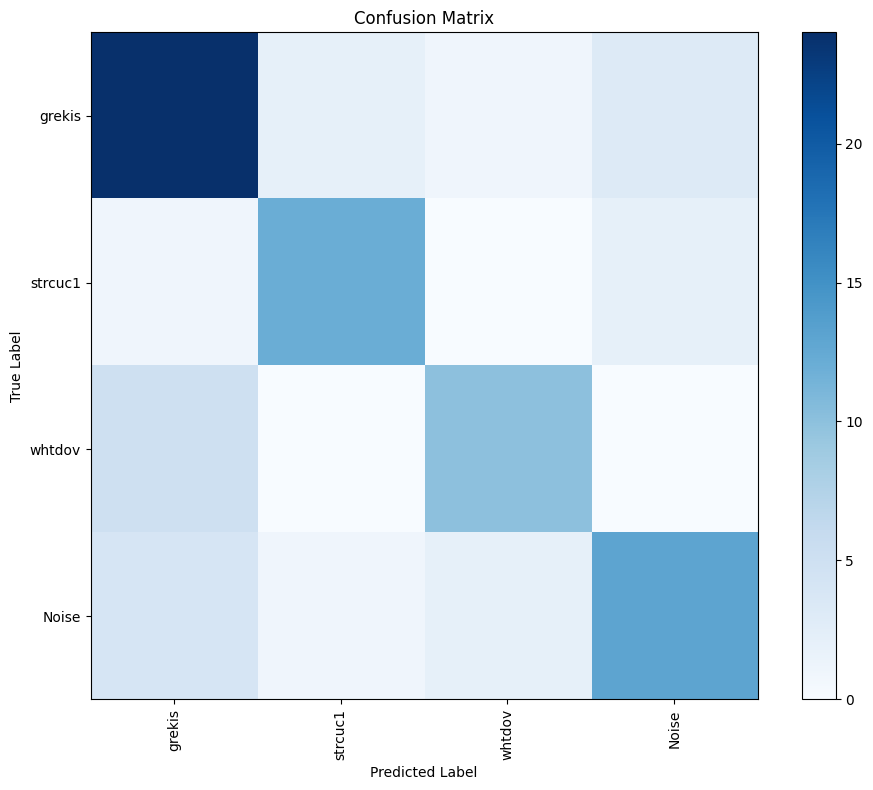

              precision    recall  f1-score   support

      grekis       0.71      0.80      0.75        30
     strcuc1       0.80      0.80      0.80        15
      whtdov       0.77      0.67      0.71        15
       Noise       0.72      0.65      0.68        20

    accuracy                           0.74        80
   macro avg       0.75      0.73      0.74        80
weighted avg       0.74      0.74      0.74        80



In [ ]:
# 8. Evaluate Model on Validation Set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val_onehot, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add class labels
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [label_to_species.get(i, 'Noise') for i in range(num_classes)], rotation=90)
plt.yticks(tick_marks, [label_to_species.get(i, 'Noise') for i in range(num_classes)])

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
class_names = [label_to_species.get(i, 'Noise') for i in range(num_classes)]
print(classification_report(y_val_true, y_val_pred_classes, target_names=class_names))

Number of bird call files: 28564
Number of background noise files: 9726


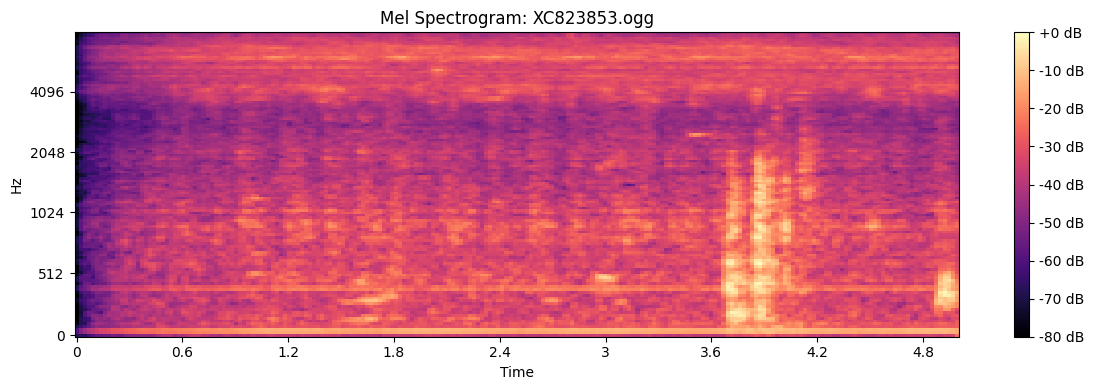

Number of species: 206
Species labels mapping: {'1139490': 0, '1192948': 1, '1194042': 2, '126247': 3, '1346504': 4, '134933': 5, '135045': 6, '1462711': 7, '1462737': 8, '1564122': 9, '21038': 10, '21116': 11, '21211': 12, '22333': 13, '22973': 14, '22976': 15, '24272': 16, '24292': 17, '24322': 18, '41663': 19, '41778': 20, '41970': 21, '42007': 22, '42087': 23, '42113': 24, '46010': 25, '47067': 26, '476537': 27, '476538': 28, '48124': 29, '50186': 30, '517119': 31, '523060': 32, '528041': 33, '52884': 34, '548639': 35, '555086': 36, '555142': 37, '566513': 38, '64862': 39, '65336': 40, '65344': 41, '65349': 42, '65373': 43, '65419': 44, '65448': 45, '65547': 46, '65962': 47, '66016': 48, '66531': 49, '66578': 50, '66893': 51, '67082': 52, '67252': 53, '714022': 54, '715170': 55, '787625': 56, '81930': 57, '868458': 58, '963335': 59, 'amakin1': 60, 'amekes': 61, 'ampkin1': 62, 'anhing': 63, 'babwar': 64, 'bafibi1': 65, 'banana': 66, 'baymac': 67, 'bbwduc': 68, 'bicwre1': 69, 'bkcdon

/home/mcavoyst/miniconda3/envs/bird_env_11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1744341690.288356   21512 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-04-10 23:21:31.363516: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56623104 exceeds 10% of free system memory.
2025-04-10 23:21:31.429614: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation o

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,156,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 207)            │        53,199 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,301,903 (54.56 MB)

 Trainable params: 14,301,903 (54.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:



# # 9. Test on New Data
# def process_test_file(file_path, model, label_to_species):
#     # Preprocess audio
#     mel_spec = preprocess_audio(file_path)
    
#     if mel_spec is not None:
#         # Reshape for model input
#         mel_spec = mel_spec.reshape(1, mel_spec.shape[0], mel_spec.shape[1], 1)
        
#         # Predict
#         prediction = model.predict(mel_spec)[0]
#         predicted_class = np.argmax(prediction)
#         confidence = prediction[predicted_class]
        
#         # Get species name
#         species = label_to_species.get(predicted_class, 'Noise')
        
#         return species, confidence
    
#     return None, None

# # Test on a few examples
# def test_on_examples(test_files, num_examples=5):
#     for i, file_path in enumerate(test_files[:num_examples]):
#         species, confidence = process_test_file(file_path, model, label_to_species)
        
#         if species is not None:
#             print(f"File: {os.path.basename(file_path)}")
#             print(f"Predicted species: {species}")
#             print(f"Confidence: {confidence:.2f}")
            
#             # Visualize
#             plot_spectrogram(file_path)
#             print("\n" + "-"*50 + "\n")

# Uncomment to test on examples
# test_on_examples(test_files)

# # 10. Function to Process a Batch of Test Files
# def batch_predict(test_files):
#     results = []
    
#     for file_path in test_files:
#         species, confidence = process_test_file(file_path, model, label_to_species)
        
#         results.append({
#             'file': os.path.basename(file_path),
#             'predicted_species': species,
#             'confidence': confidence
#         })
    
#     return pd.DataFrame(results)

# # Process all test files
# test_results = batch_predict(test_files)
# print(test_results.head())

# # 11. Save Model and Necessary Components
# # Save the trained model
# model.save('bird_call_classifier_model.h5')

# # Save the label mappings for future use
# import pickle
# with open('species_label_mapping.pkl', 'wb') as f:
#     pickle.dump({
#         'species_to_label': species_to_label,
#         'label_to_species': label_to_species
#     }, f)

# print("Model and label mappings saved successfully!")

# # 12. Advanced: Apply Data Augmentation (optional)
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def create_data_generator():
#     datagen = ImageDataGenerator(
#         width_shift_range=0.1,  # horizontal shift
#         height_shift_range=0.1,  # vertical shift
#         zoom_range=0.1,         # random zoom
#         rotation_range=5,       # rotation in degrees
#         fill_mode='nearest'     # filling strategy
#     )
#     return datagen

# Example of training with data augmentation (uncomment to use)
"""
datagen = create_data_generator()
datagen.fit(X_train)

augmented_model = build_cnn_model(input_shape, num_classes)

# Train with augmented data
history_augmented = augmented_model.fit(
    datagen.flow(X_train, y_train_onehot, batch_size=32),
    epochs=50,
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_val, y_val_onehot),
    callbacks=[early_stopping, ModelCheckpoint('best_augmented_model.h5', 
                                               monitor='val_accuracy', 
                                               save_best_only=True)],
    verbose=1
)
"""

# 13. Conclusion
"""
This notebook has created a complete pipeline for bird call classification:
1. Data loading and preprocessing of .ogg audio files
2. Feature extraction using mel spectrograms
3. CNN model building and training
4. Model evaluation and testing
5. Saving the model for future use

To improve the model:
- Increase the dataset size
- Apply more data augmentation techniques
- Try different model architectures (ResNet, EfficientNet)
- Use transfer learning from pre-trained audio models
- Implement more advanced audio preprocessing techniques
"""

In [ ]:
# Add this to the imports section
import noisereduce as nr
from pydub import AudioSegment
import io
import wave
import struct
import soundfile as sf
import scipy.signal as signal
from scipy.io import wavfile
import webrtcvad

# Add this after the audio processing section (Section 2)

# 2.5. Speech Detection and Removal
def convert_ogg_to_wav(ogg_file_path, temp_wav_path=None):
    """
    Convert OGG file to WAV format for speech processing
    """
    if temp_wav_path is None:
        temp_wav_path = ogg_file_path.replace('.ogg', '.wav')
    
    # Load OGG file using pydub
    try:
        audio = AudioSegment.from_ogg(ogg_file_path)
        audio.export(temp_wav_path, format="wav")
        return temp_wav_path
    except Exception as e:
        print(f"Error converting {ogg_file_path} to WAV: {e}")
        return None

def detect_speech_segments(wav_file_path, frame_duration_ms=30, aggressiveness=3):
    """
    Use WebRTC VAD to detect speech segments in audio
    
    Parameters:
    wav_file_path (str): Path to WAV file
    frame_duration_ms (int): Frame duration in milliseconds
    aggressiveness (int): VAD aggressiveness (0-3)
    
    Returns:
    speech_segments: List of tuples with (start_time, end_time) in seconds
    """
    # Load the WAV file
    sample_rate, audio = wavfile.read(wav_file_path)
    
    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    # Convert to 16-bit PCM
    if audio.dtype != np.int16:
        audio = (audio * 32767).astype(np.int16)
    
    # Initialize VAD
    vad = webrtcvad.Vad()
    vad.set_mode(aggressiveness)
    
    # Calculate frame size and prepare frames
    frame_size = int(sample_rate * frame_duration_ms / 1000)
    # Ensure the frame size is compatible with WebRTC VAD
    frame_size_samples = int(sample_rate * frame_duration_ms / 1000)
    frame_size_bytes = frame_size_samples * 2  # 16-bit audio, so 2 bytes per sample
    
    # Prepare audio frames
    frames = []
    for i in range(0, len(audio) - frame_size_samples, frame_size_samples):
        frame = audio[i:i + frame_size_samples]
        frames.append(frame)
    
    # Detect speech in each frame
    speech_frames = []
    for i, frame in enumerate(frames):
        # Convert frame to bytes in required format
        frame_bytes = struct.pack("h" * len(frame), *frame)
        try:
            is_speech = vad.is_speech(frame_bytes, sample_rate)
            speech_frames.append(is_speech)
        except Exception as e:
            speech_frames.append(False)
            print(f"Error in VAD processing: {e}")
    
    # Find continuous speech segments
    speech_segments = []
    in_speech = False
    start_frame = 0
    
    for i, is_speech in enumerate(speech_frames):
        if is_speech and not in_speech:
            in_speech = True
            start_frame = i
        elif not is_speech and in_speech:
            in_speech = False
            # Convert frame indices to time in seconds
            start_time = start_frame * frame_duration_ms / 1000
            end_time = i * frame_duration_ms / 1000
            speech_segments.append((start_time, end_time))
    
    # Handle the case where audio ends during speech
    if in_speech:
        start_time = start_frame * frame_duration_ms / 1000
        end_time = len(speech_frames) * frame_duration_ms / 1000
        speech_segments.append((start_time, end_time))
    
    return speech_segments

def remove_speech_from_audio(ogg_file_path, output_path=None):
    """
    Remove detected speech segments from audio and return the cleaned audio
    
    Parameters:
    ogg_file_path (str): Path to OGG file
    output_path (str): Path to save cleaned audio (if None, will be generated)
    
    Returns:
    cleaned_audio: NumPy array of audio with speech removed
    sample_rate: Sample rate of the audio
    """
    if output_path is None:
        output_path = ogg_file_path.replace('.ogg', '_cleaned.ogg')
    
    # Convert to WAV for processing
    temp_wav_path = convert_ogg_to_wav(ogg_file_path)
    
    if temp_wav_path is None:
        print(f"Couldn't convert {ogg_file_path} to WAV. Skipping speech removal.")
        return None, None
    
    # Load the audio
    sample_rate, audio = wavfile.read(temp_wav_path)
    
    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    # Detect speech segments
    speech_segments = detect_speech_segments(temp_wav_path)
    
    # If no speech detected, return original audio
    if not speech_segments:
        # Clean up temporary file
        if os.path.exists(temp_wav_path):
            os.remove(temp_wav_path)
        return audio, sample_rate
    
    # Create a mask for non-speech regions
    mask = np.ones(len(audio), dtype=bool)
    
    for start_time, end_time in speech_segments:
        start_sample = int(start_time * sample_rate)
        end_sample = int(end_time * sample_rate)
        
        # Ensure indices are within bounds
        start_sample = max(0, start_sample)
        end_sample = min(len(audio), end_sample)
        
        # Mark speech regions to be removed
        mask[start_sample:end_sample] = False
    
    # Apply mask to keep only non-speech regions
    cleaned_audio = audio[mask]
    
    # Apply additional noise reduction to the cleaned audio
    cleaned_audio = nr.reduce_noise(
        y=cleaned_audio.astype(float), 
        sr=sample_rate
    )
    
    # Save the cleaned audio
    sf.write(output_path, cleaned_audio, sample_rate)
    
    # Clean up temporary file
    if os.path.exists(temp_wav_path):
        os.remove(temp_wav_path)
    
    return cleaned_audio, sample_rate

# Function to preprocess audio file with speech removal
def preprocess_audio_with_speech_removal(file_path, sr=22050, duration=5):
    """
    Load an audio file, remove speech, and extract mel spectrogram features
    
    Parameters:
    file_path (str): Path to the audio file
    sr (int): Target sample rate
    duration (int): Duration in seconds to load
    
    Returns:
    mel_spectrogram: Mel spectrogram of the cleaned audio
    """
    try:
        # Remove speech from the audio
        cleaned_audio, orig_sr = remove_speech_from_audio(file_path)
        
        if cleaned_audio is None:
            # Fall back to original audio processing if speech removal fails
            return preprocess_audio(file_path, sr, duration)
        
        # Resample to target sample rate if needed
        if orig_sr != sr:
            cleaned_audio = librosa.resample(
                cleaned_audio.astype(float), 
                orig_sr=orig_sr, 
                target_sr=sr
            )
        
        # Trim or pad to target duration
        target_length = sr * duration
        if len(cleaned_audio) > target_length:
            cleaned_audio = cleaned_audio[:target_length]
        elif len(cleaned_audio) < target_length:
            cleaned_audio = np.pad(cleaned_audio, (0, target_length - len(cleaned_audio)))
        
        # Extract mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=cleaned_audio, 
            sr=sr, 
            n_mels=128, 
            fmax=8000
        )
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        return mel_spectrogram
    except Exception as e:
        print(f"Error processing file {file_path} with speech removal: {e}")
        # Fall back to original audio processing
        return preprocess_audio(file_path, sr, duration)

# Visualization function to compare original and cleaned audio
def visualize_speech_removal(file_path):
    """
    Visualize the effect of speech removal on an audio file
    """
    # Process original audio
    y_orig, sr_orig = librosa.load(file_path, sr=22050, duration=5)
    mel_orig = librosa.feature.melspectrogram(y=y_orig, sr=sr_orig, n_mels=128, fmax=8000)
    mel_db_orig = librosa.power_to_db(mel_orig, ref=np.max)
    
    # Process cleaned audio
    cleaned_audio, sr_cleaned = remove_speech_from_audio(file_path)
    if sr_cleaned != sr_orig:
        cleaned_audio = librosa.resample(cleaned_audio.astype(float), orig_sr=sr_cleaned, target_sr=sr_orig)
    
    mel_cleaned = librosa.feature.melspectrogram(y=cleaned_audio, sr=sr_orig, n_mels=128, fmax=8000)
    mel_db_cleaned = librosa.power_to_db(mel_cleaned, ref=np.max)
    
    # Visualize
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y_orig, sr=sr_orig)
    plt.title('Original Audio Waveform')
    
    plt.subplot(2, 2, 2)
    librosa.display.specshow(mel_db_orig, sr=sr_orig, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original Mel Spectrogram')
    
    plt.subplot(2, 2, 3)
    librosa.display.waveshow(cleaned_audio, sr=sr_orig)
    plt.title('Cleaned Audio Waveform (Speech Removed)')
    
    plt.subplot(2, 2, 4)
    librosa.display.specshow(mel_db_cleaned, sr=sr_orig, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Cleaned Mel Spectrogram')
    
    plt.tight_layout()
    plt.show()
    
    # Play original and cleaned audio
    print("Original Audio:")
    ipd.display(ipd.Audio(y_orig, rate=sr_orig))
    
    print("Cleaned Audio (Speech Removed):")
    ipd.display(ipd.Audio(cleaned_audio, rate=sr_orig))

# Update the prepare_dataset function to use speech removal
def prepare_dataset_with_speech_removal(file_list, species_to_label=None, is_background_noise=False):
    """
    Process audio files with speech removal and prepare a dataset with features and labels
    """
    X = []
    y = []
    
    for file_path in file_list:
        mel_spec = preprocess_audio_with_speech_removal(file_path)
        
        if mel_spec is not None:
            X.append(mel_spec)
            
            if is_background_noise:
                # Background noise is labeled as -1 or a specific class
                y.append(-1)  # or len(species_to_label) if you want a separate class
            else:
                species = extract_species(file_path)
                label = species_to_label.get(species, -1)
                y.append(label)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Reshape for CNN input: (samples, height, width, channels)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    
    return X, y

# Test the speech removal on a sample file (uncomment to test)
# if len(bird_call_files) > 0:
#    visualize_speech_removal(bird_call_files[0])

# Update the data preparation in the main workflow (replace the appropriate section)
# Process bird call files with speech removal
bird_call_files
X_bird, y_bird = prepare_dataset_with_speech_removal(bird_call_files, species_to_label, is_background_noise=False)

# # Process background noise files with speech removal
# X_noise, y_noise = prepare_dataset_with_speech_removal(background_noise_files, species_to_label, is_background_noise=True)

# # Combine datasets if needed (optional)
# X_combined = np.vstack((X_bird, X_noise))
# y_combined = np.concatenate((y_bird, y_noise))

# # If you want to treat background noise as a separate class:
# y_combined[y_combined == -1] = len(species_to_label)

# print(f"Combined dataset shape: {X_combined.shape}")
# print(f"Unique labels: {np.unique(y_combined)}")


NameError: name 'bird_call_files' is not defined

In [ ]:
# Download latest version
path = kagglehub.model_download("google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier")

print("Path to model files:", path)

100%|██████████| 8.21k/8.21k [00:00<00:00, 6.83MB/s]


100%|██████████| 26.0/26.0 [00:00<00:00, 19.5kB/s]


100%|██████████| 658/658 [00:00<00:00, 523kB/s]


100%|██████████| 3.28k/3.28k [00:00<00:00, 2.47MB/s]


100%|██████████| 95.0k/95.0k [00:00<00:00, 1.39MB/s]




100%|██████████| 26.6k/26.6k [00:00<00:00, 711kB/s]



100%|██████████| 3.70M/3.70M [00:00<00:00, 5.43MB/s]
100%|██████████| 91.4M/91.4M [00:02<00:00, 37.7MB/s]

Path to model files: /home/mcavoyst/.cache/kagglehub/models/google/bird-vocalization-classifier/tensorFlow2/bird-vocalization-classifier/8


In [ ]:
len(class_labels)

206

primary_label  inat_taxon_id               scientific_name  \
0       1139490        1139490          Ragoniella pulchella   
1       1192948        1192948         Oxyprora surinamensis   
2       1194042        1194042           Copiphora colombiae   
3        126247         126247       Leptodactylus insularum   
4       1346504        1346504  Neoconocephalus brachypterus   
5        134933         134933        Espadarana prosoblepon   
6        135045         135045      Andinobates opisthomelas   
7       1462711        1462711         Cocconotus aratifrons   
8       1462737        1462737        Docidocercus fasciatus   

                    common_name class_name  
0          Ragoniella pulchella    Insecta  
1         Oxyprora surinamensis    Insecta  
2           Copiphora colombiae    Insecta  
3        Spotted Foam-nest Frog   Amphibia  
4  Neoconocephalus brachypterus    Insecta  
5            Emerald Glass Frog   Amphibia  
6            Andean Poison Frog   Amphibia  
7         Cocconotus aratifrons    Insecta  
8        Docidocercus fasciatus    Insecta

In [ ]:
taxonomy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   primary_label    206 non-null    object
 1   inat_taxon_id    206 non-null    int64 
 2   scientific_name  206 non-null    object
 3   common_name      206 non-null    object
 4   class_name       206 non-null    object
dtypes: int64(1), object(4)
memory usage: 8.2+ KB


In [ ]:
taxonomy.primary_label.nunique()

206

In [ ]:
taxonomy.scientific_name.nunique()

206

PLAN:

Question - is there a need to sub-specify the call type i.e. distress or mating etc.

- focus on one class at a time
- Maybe use the insect and ambibians to subtract them out.
- overlay the correct birds etc with associated backgrounds to create additional training data. 
- Pre-clean with model detecting human speach or language to remove those clips
  - chunk audio and clean each chunk then can recombine if needed
  - 
* Clustering analysis too to seperate the different types of bird calls?

In [ ]:
test_soundscapes[:2]

[]

(1, 10932)
(1, 2333)
(1, 249)
(1, 41)
(1, 1280)


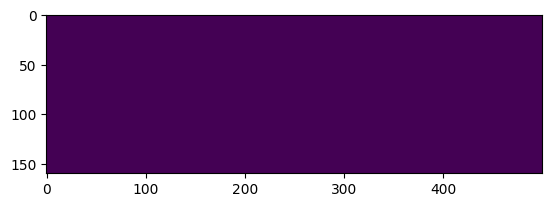

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Load the model.
model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')

# Input: 5 seconds of silence as mono 32 kHz waveform samples.
waveform = np.zeros(5 * 32000, dtype=np.float32)

# Run the model, check the output.
model_outputs = model.infer_tf(waveform[np.newaxis, :])

# Examine the spectrogram.
plt.imshow(model_outputs['frontend'][0].T)

# Examine various logits.
print(model_outputs['label'].shape)
print(model_outputs['genus'].shape)
print(model_outputs['family'].shape)
print(model_outputs['order'].shape)

# Examine the embeddings.
print(model_outputs['embedding'].shape)


In [ ]:
waveform

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
soundscape = librosa.load('/kaggle/input/birdclef-2025/train_soundscapes/H02_20230420_074000.ogg')



(22050,)

BirdCLEF+ 2025 Sample Submission
This is a quick run through the submission process. Test data is hidden, so we can't access it before submission. In order to make a valid submission, here's what we'll do:

Make sure we predict for all 206 classes in the train data
Load a list of test soundscapes
Process each soundscape
load audio
split into 5-second chunks
run model inference for each chunk
save predictions
Make submission csv file
Submit
Ok, so here we go.

In order to make a submission, we need to:

disable internet for this notebook (Settings --> Turn off internet)
make sure the notebook runs without errors and a submission file gets created
submit to competition (panel on the right)
wait for the notebook to finish (this may take a while, remember there's a 90-min time limit)
If all goes well, we should see our submission scores on the leaderboard.

In [ ]:
# Open each soundscape and make predictions for 5-second segments
# Use pandas df with 'row_id' plus class labels as columns
predictions = pd.DataFrame(columns=['row_id'] + class_labels)
for soundscape in test_soundscapes:

    # Load audio
    sig, rate = librosa.load(path=soundscape, sr=None)

    # Split into 5-second chunks
    chunks = []
    for i in range(0, len(sig), rate*5):
        chunk = sig[i:i+rate*5]
        chunks.append(chunk)
        
    # Make predictions for each chunk
    for i, chunk in enumerate(chunks):
        
        # Get row id  (soundscape id + end time of 5s chunk)      
        row_id = os.path.basename(soundscape).split('.')[0] + f'_{i * 5 + 5}'
        
        # Make prediction (let's use random scores for now)
        # scores = model.predict...
        scores = np.random.rand(len(class_labels))
        
        # Append to predictions as new row
        new_row = pd.DataFrame([[row_id] + list(scores)], columns=['row_id'] + class_labels)
        predictions = pd.concat([predictions, new_row], axis=0, ignore_index=True)

In [ ]:
# Open each soundscape and make predictions for 5-second segments
# Use pandas df with 'row_id' plus class labels as columns
predictions = pd.DataFrame(columns=['row_id'] + class_labels)
for soundscape in test_soundscapes:

    # Load audio
    sig, rate = librosa.load(path=soundscape, sr=None)

    # Split into 5-second chunks
    chunks = []
    for i in range(0, len(sig), rate*5):
        chunk = sig[i:i+rate*5]
        chunks.append(chunk)
        
    # Make predictions for each chunk
    for i, chunk in enumerate(chunks):
        
        # Get row id  (soundscape id + end time of 5s chunk)      
        row_id = os.path.basename(soundscape).split('.')[0] + f'_{i * 5 + 5}'
        
        # Make prediction (let's use random scores for now)
        # scores = model.predict...
        scores = np.random.rand(len(class_labels))
        
        # Append to predictions as new row
        new_row = pd.DataFrame([[row_id] + list(scores)], columns=['row_id'] + class_labels)
        predictions = pd.concat([predictions, new_row], axis=0, ignore_index=True)
        
# Save prediction as csv
predictions.to_csv('submission.csv', index=False)
predictions.head()
        

In [ ]:
# Save prediction as csv
predictions.to_csv('submission.csv', index=False)
predictions.head()